# Deep Neural Networks
In this notebook, we will be building a neural network from scratch. It's going to be a simple neural network with only forward weights. With that respect, it will be a *feed-forward* neural network. Most of this material will be adapted from the book, [Learning from Data](http://amlbook.com/). 

## The Structure
Picture from Learning From Data, Chapter 7 by AML.

<img src="nn.png">

Let's get the notation down. First, the neural network above has **three** layers. We don't count the input layer, because it is usually just the raw data. Each layer has a certain number of nodes. For example, the $l=2$ layer above has $3$ nodes. In general, layer $l$ will have $d^{(l)} + 1$ nodes. The $+1$ results from the bias node. Now, let's name each node. For example, the last node on layer $l=0$ can be written as $x^{(0)}_{d^{(0)}}$. We also need to define the weights. $w^{(l)}_{ij}$ refers to the weight that connects $x^{(l-1)}_{i}$ to $x^{(l)}_{j}$. So summarizing this all in bullets
* $x^{(l)}_{i}$ is the *i*th node from layer $l$
* Each layer $l$ has $d^{(l)} + 1$ nodes

The following our bounds on $w^{(l)}_{ij}$, the weight that connects $x^{(l-1)}_{i}$ to $x^{(l)}_{j}$:
* $0 \le i \le d^{(l-1)}$
* $1 \le j \le d^{(l)}$
* $0 \le l \le L$

Notice how $j$ is lower bounded by $1$. In the above diagram, no weights are going into the bias nodes. This is convention we will use for our deep neural network.
## Imports ##
We will only be using *numpy* for vectorization and perhaps *matplotlib* for plotting. We will code forward and back propogation from scratch.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## MNIST DATA ##
We will be making use of the mnist hand-written digits dataset. You can run ** pip install mnist** to get this package. The following cell block will load the train/test images and associated labels.

In [3]:
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [7]:
print(train_images.max(), test_images.max())
print(train_images.min(), test_images.min())

255 255
0 0


I'm going to normalize these images so that our data points are strictly between 0 and 1.

In [8]:
train_images = train_images / train_images.max()
test_images  = test_images  / test_images.max()

In [9]:
train_images.shape

(60000, 28, 28)

In [10]:
test_images.shape

(10000, 28, 28)

So we have 60,000 training images and 10,000 test images. Let's plot one of the training images just to see what it looks like.

Label for train_images[1000]: 0


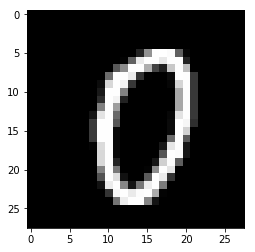

In [14]:
print("Label for train_images[1000]: %d" % train_labels[1000])
plt.imshow(train_images[1000], cmap='gray')

Great, we can see that the image is clearly a zero and the label matches. Let's analyze one training image a bit further.

In [15]:
train_images[1000].shape

(28, 28)

So we have a 28 by 28 grid of pixel values between 0 and 1. I would like this to be the input to our deep neural network. Therefore, our zeroth layer will have 785 nodes (28 x 28 + 1).

# Coding a Deep Neural Network

Our network will have 784, 16, 16, and 10 nodes in each layer (excluding the bias node except for the last layer). The last layer has 10 nodes, each node representing the probability that the input images corresponds to that digit. To squeeze a function into a probabalistic model, we will use the sigmoid function for the last layer and $tanh$ function for all other layers.

In [26]:
d = {0:784, 1:16, 2:16, 3:10}
num_layers = len(d) - 1
print(len(d))

4



We will be using $tanh(x)$ as the activation functions for all but the last layer. It has some nice properties (ranges from -1 to 1 and is differentiable). Also the derivative of $tanh(x)$ is $1 - tanh(x)^2$. Recall to set the weights to small random numbers as our function is not convex; we don't want to get stuck at a local minima.

In [27]:
W       = {}
S       = {}
X       = {}
deltas  = {}  
grads   = {}
for l in range(1,len(d)):
    W[l]      = np.random.normal(0,0.1,(d[l-1] + 1, d[l]))
    grads[l]  = np.zeros((d[l-1] + 1, d[l]))
    S[l]      = np.zeros((d[l],1))
    X[l]      = np.ones((d[l] + 1,1))
    deltas[l] = np.zeros((d[l],1))
X[0] = np.ones((d[0] + 1,1))

In [28]:
def h(x):
    feed_forward(x, W, S)
    return X[num_layers][1:]

In [29]:
def theta(x):
    return np.tanh(x)

def theta_prime(x):
    return 1 - np.tanh(x)*np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return 1 / (1 + np.exp(-x)) * (1 - 1 / (1 + np.exp(-x)))

### Feed Forward ###

In [30]:
def feed_forward(x, W, S):
    X[0] = x.reshape(X[0].shape[0], 1)
    for l in range(1, len(d)):
        S[l] = np.matmul(W[l].T, X[l-1]).reshape(S[l].shape[0], 1)
#         X[l][1:] = sigmoid(S[l])
        if l == num_layers:
            X[l][1:] = sigmoid(S[l])
        else:
            X[l][1:] = theta(S[l])

### Back Prop ###
The minimizer of deep neural networks. Here, we are using dynamic programming to speed up the computation.

In [31]:
def back_prop(deltas, X, S):
    for l in range(num_layers - 1, 0, -1):
        deltas[l] = sigmoid_prime(S[l]) * np.matmul(W[l + 1][1:], deltas[l+1])
        grads[l]  = np.matmul(X[l-1], deltas[l].T)

### Stochastic Gradient Descent ###

We will put feed forward and back prop into our stochastic grad descent. We use stochastic to decrease overall runtime and help us avoid being trapped in local extrema.

In [32]:
def StochasticGradientDescent(W, S, deltas, eta, iterations):
    num = iterations // 2
    for i in range(iterations):
        if i == num:
            print("halfway through.")
        idx = np.random.randint(0, train_images.shape[0])
        x = np.append([1], train_images[idx].flatten())
        curr_y = np.zeros((10,1))
        curr_y[train_labels[idx]] = 1
        feed_forward(x, W, S) 
        deltas[num_layers] = 2 * (X[num_layers][1:] - curr_y) * sigmoid_prime(S[num_layers])
        grads[num_layers] = np.matmul(X[num_layers-1], deltas[num_layers].T)
        back_prop(deltas, X, S)
        for l in range(1,len(d)):
            W[l] = W[l] - eta * grads[l]

# Running Stochastic Gradient Descent (takes time to run)

This function takes around 1 hour to run on my machine. Again, there will inefficiences as this was coded from scratch. A package like tensorflow or keras would be much faster.

In [178]:
StochasticGradientDescent(W, S, deltas, eta=0.1, iterations=10000000) 

halfway through.


## Save the weights ##
Let's save the weights for later use.

In [38]:
# np.save("weights.dict", W)
# read_dictionary = np.load('weights.dict.npy').item()
# W = read_dictionary

# Testing the Deep Neural Network
Overall, we see a 6.08% training error and a 6.83 test error! So it classified most images correctly.

In [45]:
total = 0
import warnings
warnings.filterwarnings('ignore')
for i in range(len(train_images)):
    curr_x = np.append([1], train_images[i].flatten())
    curr_y = train_labels[i]
    if np.argmax(h(curr_x)) == curr_y:
        total += 1
print("Training Error:",  (len(train_images) - total)/len(train_images))

Training Error: 0.0608


In [46]:
total = 0
incorrect_idx = []
for i in range(len(test_images)):
    curr_x = np.append([1], test_images[i].flatten())
    curr_y = test_labels[i]
    if (np.argmax(h(curr_x))) == curr_y:
        total +=1
    else:
        incorrect_idx.append(i)
print("Test Error:",  (len(test_images) - total)/len(test_images))

Test Error: 0.0683


## Plotting an incorrect Image ##
Here, we see that the deep neural network chose to label this image as a 9 instead of a 7.

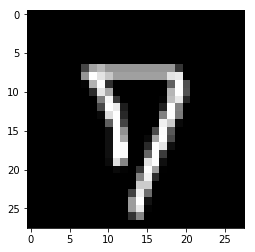

In [51]:
i = 100
plt.imshow(test_images[incorrect_idx[i]], cmap='gray')

In [52]:
test_labels[incorrect_idx[i]]

7

In [53]:
np.argmax(h(np.append([1], test_images[incorrect_idx[i]].flatten())))

9